# Sklearn Tuner for LSTM Activity Classifier 

In this notebook, we use SKlearn  to tune a LSTM neural net to classify PE activity.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import sklearn
# bug in sklearn wrapper
#https://stackoverflow.com/questions/59746974/cannot-clone-object-tensorflow-python-keras-wrappers-scikit-learn-kerasclassifi
if sklearn.__version__ != '0.21.2':
    print("updating sklearn ...")
    !pip install --user scikit-learn==0.21.2
    


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1276608612805494057
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12984453876963605300
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4408072045768815224
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13974246354186393395
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


#### Set hyperparameters

In [21]:
# output directory name:
output_dir = 'model_output/tune-lstm'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [22]:
# sklearn hyperparams
params = {
    
    # LSTM layers
    'n_lstm_1' : [128, 256],
    'n_lstm_2' : [128, 256],
    'n_lstm_3' : [128, 256],
    'n_lstm_4' : [128, 256],
    'drop_lstm_1' : [0.02,0.1],
    'drop_lstm_2' : [0.02,0.1],
    'drop_lstm_3' : [0.02,0.1],
    'drop_lstm_4' : [0.02,0.1],

    
    # Dense layers
    'n_dense_1':[256, 384, 512],
    'dropout_1':[0.2, 0.3],
    'n_dense_2':[256, 384, 512],
    'dropout_2':[0.2, 0.3],
    'activation_conv':['elu', 'relu', LeakyReLU()],
    'activation_dense':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 20
cv = 3
epochs = 60
batch_size = 256


In [23]:
# Try to get reproducable results
from numpy.random import seed
seed(85)
from tensorflow.random import set_seed
set_seed(75)

#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [24]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [25]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [26]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [27]:
y = to_categorical(labels_array_int, num_classes=n_class)

### Splitting and shuffeling the data

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [29]:
params

{'n_lstm_1': [128, 256],
 'n_lstm_2': [128, 256],
 'n_lstm_3': [128, 256],
 'n_lstm_4': [128, 256],
 'drop_lstm_1': [0.02, 0.1],
 'drop_lstm_2': [0.02, 0.1],
 'drop_lstm_3': [0.02, 0.1],
 'drop_lstm_4': [0.02, 0.1],
 'n_dense_1': [256, 384, 512],
 'dropout_1': [0.2, 0.3],
 'n_dense_2': [256, 384, 512],
 'dropout_2': [0.2, 0.3],
 'activation_conv': ['elu',
  'relu',
 'activation_dense': ['elu',
  'relu',
  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x1b6fb510788>]}

In [30]:
def create_model( n_lstm_1=128, n_lstm_2=128, n_lstm_3=128, n_lstm_4=128, drop_lstm_1=0.02, drop_lstm_2=0.02,
                 drop_lstm_3=0.02,drop_lstm_4=0.02, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation_conv= 'relu', activation_dense= 'elu'
                ):
    model = Sequential()
    # LSTM layers
    model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True, input_shape=input_shape[1:])) 
    model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
    model.add(LSTM(n_lstm_3, dropout=drop_lstm_3, 
                             return_sequences=True)) 
    model.add(LSTM(n_lstm_4, dropout=drop_lstm_4, 
                             return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(n_dense_1, activation=activation_dense))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation_dense))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.summary()
    print(f"""
          n_lstm_1 = {n_lstm_1}, n_lstm_2 = {n_lstm_2}, n_lstm_3 = {n_lstm_3}, n_lstm_4 = {n_lstm_4},
          drop_lstm_1 = {drop_lstm_1}, drop_lstm_2 = {drop_lstm_2},
          drop_lstm_3 = {drop_lstm_3}, drop_lstm_4 = {drop_lstm_4},
          n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation_conv=  {activation_conv},
          activation_dense=  {activation_dense}""")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [31]:
model_default = create_model()
# model_default.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 90, 128)           67584     
_________________________________________________________________
lstm_17 (LSTM)               (None, 90, 128)           131584    
_________________________________________________________________
lstm_18 (LSTM)               (None, 90, 128)           131584    
_________________________________________________________________
lstm_19 (LSTM)               (None, 90, 128)           131584    
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2949376   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [32]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [33]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 90, 256)           266240    
_________________________________________________________________
lstm_21 (LSTM)               (None, 90, 128)           197120    
_________________________________________________________________
lstm_22 (LSTM)               (None, 90, 256)           394240    
_________________________________________________________________
lstm_23 (LSTM)               (None, 90, 256)           525312    
_________________________________________________________________
flatten_5 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               5898496   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)              

152/152 [==============================] - 21s 140ms/step - loss: 0.1240 - accuracy: 0.9512
Epoch 59/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1178 - accuracy: 0.9522
Epoch 60/60
76/76 [==============================] - 4s 50ms/step - loss: 0.3227 - accuracy: 0.9095
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 90, 256)           266240    
_________________________________________________________________
lstm_25 (LSTM)               (None, 90, 128)           197120    
_________________________________________________________________
lstm_26 (LSTM)               (None, 90, 256)           394240    
_________________________________________________________________
lstm_27 (LSTM)               (None, 90, 256)           525312    
_________________________________________________________________
flatten_6 (Flatten)   

152/152 [==============================] - 21s 140ms/step - loss: 0.1294 - accuracy: 0.9474
Epoch 56/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1280 - accuracy: 0.9496
Epoch 57/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1305 - accuracy: 0.9477
Epoch 58/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1188 - accuracy: 0.9526
Epoch 59/60
152/152 [==============================] - 21s 141ms/step - loss: 0.1185 - accuracy: 0.9531
Epoch 60/60
76/76 [==============================] - 4s 50ms/step - loss: 0.4246 - accuracy: 0.8875
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 90, 256)           266240    
_________________________________________________________________
lstm_29 (LSTM)               (None, 90, 128)           197120    
________________________________________

152/152 [==============================] - 21s 140ms/step - loss: 0.1369 - accuracy: 0.9462
Epoch 53/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1366 - accuracy: 0.9447
Epoch 54/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1303 - accuracy: 0.9480
Epoch 55/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1286 - accuracy: 0.9477
Epoch 56/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1233 - accuracy: 0.9499
Epoch 57/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1225 - accuracy: 0.9500
Epoch 58/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1248 - accuracy: 0.9509
Epoch 59/60
152/152 [==============================] - 21s 140ms/step - loss: 0.1308 - accuracy: 0.9488
Epoch 60/60
76/76 [==============================] - 4s 50ms/step - loss: 0.4379 - accuracy: 0.8800
Model: "sequential_8"
__________________________________________________________

152/152 [==============================] - 23s 150ms/step - loss: 0.1304 - accuracy: 0.9466
Epoch 51/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1347 - accuracy: 0.9463
Epoch 52/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1240 - accuracy: 0.9510
Epoch 53/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1292 - accuracy: 0.9496
Epoch 54/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1185 - accuracy: 0.9513
Epoch 55/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1215 - accuracy: 0.9497
Epoch 56/60
152/152 [==============================] - 23s 150ms/step - loss: 0.1263 - accuracy: 0.9483
Epoch 57/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1310 - accuracy: 0.9487
Epoch 58/60
152/152 [==============================] - 23s 150ms/step - loss: 0.1194 - accuracy: 0.9526
Epoch 59/60
152/152 [==============================] - 23s 151ms/step - loss

152/152 [==============================] - 23s 151ms/step - loss: 0.1411 - accuracy: 0.9429
Epoch 49/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1420 - accuracy: 0.9435
Epoch 50/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1317 - accuracy: 0.9463
Epoch 51/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1317 - accuracy: 0.9464
Epoch 52/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1281 - accuracy: 0.9472
Epoch 53/60
152/152 [==============================] - 23s 150ms/step - loss: 0.1301 - accuracy: 0.9468
Epoch 54/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1242 - accuracy: 0.9493
Epoch 55/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1264 - accuracy: 0.9494
Epoch 56/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1357 - accuracy: 0.9463
Epoch 57/60
152/152 [==============================] - 23s 151ms/step - loss

152/152 [==============================] - 23s 150ms/step - loss: 0.1484 - accuracy: 0.9407
Epoch 47/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1337 - accuracy: 0.9464
Epoch 48/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1355 - accuracy: 0.9471
Epoch 49/60
152/152 [==============================] - 23s 150ms/step - loss: 0.1345 - accuracy: 0.9463
Epoch 50/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1312 - accuracy: 0.9470
Epoch 51/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1299 - accuracy: 0.9468
Epoch 52/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1325 - accuracy: 0.9476
Epoch 53/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1244 - accuracy: 0.9490
Epoch 54/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1303 - accuracy: 0.9478
Epoch 55/60
152/152 [==============================] - 23s 151ms/step - loss

152/152 [==============================] - 22s 145ms/step - loss: 0.1621 - accuracy: 0.9377
Epoch 45/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1517 - accuracy: 0.9404
Epoch 46/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1641 - accuracy: 0.9344
Epoch 47/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1435 - accuracy: 0.9422
Epoch 48/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1477 - accuracy: 0.9393
Epoch 49/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1543 - accuracy: 0.9371
Epoch 50/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1456 - accuracy: 0.9413
Epoch 51/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1444 - accuracy: 0.9418
Epoch 52/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1459 - accuracy: 0.9418
Epoch 53/60
152/152 [==============================] - 22s 145ms/step - loss

152/152 [==============================] - 22s 145ms/step - loss: 0.1522 - accuracy: 0.9391
Epoch 43/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1548 - accuracy: 0.9366
Epoch 44/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1671 - accuracy: 0.9325
Epoch 45/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1514 - accuracy: 0.9383
Epoch 46/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1549 - accuracy: 0.9377
Epoch 47/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1498 - accuracy: 0.9396
Epoch 48/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1442 - accuracy: 0.9403
Epoch 49/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1480 - accuracy: 0.9394
Epoch 50/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1476 - accuracy: 0.9400
Epoch 51/60
152/152 [==============================] - 22s 145ms/step - loss

152/152 [==============================] - 22s 145ms/step - loss: 0.1697 - accuracy: 0.9315
Epoch 41/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1701 - accuracy: 0.9307
Epoch 42/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1673 - accuracy: 0.9331
Epoch 43/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1608 - accuracy: 0.9342
Epoch 44/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1545 - accuracy: 0.9369
Epoch 45/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1569 - accuracy: 0.9367
Epoch 46/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1561 - accuracy: 0.9362
Epoch 47/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1525 - accuracy: 0.9386
Epoch 48/60
152/152 [==============================] - 22s 145ms/step - loss: 0.1489 - accuracy: 0.9399
Epoch 49/60
152/152 [==============================] - 22s 145ms/step - loss

152/152 [==============================] - 19s 123ms/step - loss: 0.1762 - accuracy: 0.9292
Epoch 39/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1689 - accuracy: 0.9335
Epoch 40/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1638 - accuracy: 0.9343
Epoch 41/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1558 - accuracy: 0.9385
Epoch 42/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1689 - accuracy: 0.9333
Epoch 43/60
152/152 [==============================] - 19s 122ms/step - loss: 0.1634 - accuracy: 0.9358
Epoch 44/60
152/152 [==============================] - 19s 122ms/step - loss: 0.1545 - accuracy: 0.9386
Epoch 45/60
152/152 [==============================] - 19s 122ms/step - loss: 0.1555 - accuracy: 0.9375
Epoch 46/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1519 - accuracy: 0.9401
Epoch 47/60
152/152 [==============================] - 19s 123ms/step - loss

152/152 [==============================] - 19s 123ms/step - loss: 0.1927 - accuracy: 0.9210
Epoch 34/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1906 - accuracy: 0.9222
Epoch 35/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1879 - accuracy: 0.9238
Epoch 36/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1803 - accuracy: 0.9289
Epoch 37/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1682 - accuracy: 0.9328
Epoch 38/60
152/152 [==============================] - 19s 122ms/step - loss: 0.1830 - accuracy: 0.9246
Epoch 39/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1781 - accuracy: 0.9274
Epoch 40/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1702 - accuracy: 0.9309
Epoch 41/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1586 - accuracy: 0.9352
Epoch 42/60
152/152 [==============================] - 19s 123ms/step - loss

152/152 [==============================] - 19s 123ms/step - loss: 0.2015 - accuracy: 0.9187
Epoch 32/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1963 - accuracy: 0.9208
Epoch 33/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1854 - accuracy: 0.9249
Epoch 34/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1818 - accuracy: 0.9275
Epoch 35/60
152/152 [==============================] - 19s 122ms/step - loss: 0.1787 - accuracy: 0.9293
Epoch 36/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1766 - accuracy: 0.9281
Epoch 37/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1752 - accuracy: 0.9306
Epoch 38/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1741 - accuracy: 0.9318
Epoch 39/60
152/152 [==============================] - 19s 123ms/step - loss: 0.1643 - accuracy: 0.9334
Epoch 40/60
152/152 [==============================] - 19s 123ms/step - loss

152/152 [==============================] - 10s 69ms/step - loss: 0.2373 - accuracy: 0.9062
Epoch 30/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2312 - accuracy: 0.9099
Epoch 31/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2239 - accuracy: 0.9118
Epoch 32/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2169 - accuracy: 0.9152
Epoch 33/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2135 - accuracy: 0.9161
Epoch 34/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2083 - accuracy: 0.9180
Epoch 35/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2056 - accuracy: 0.9187
Epoch 36/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2076 - accuracy: 0.9189
Epoch 37/60
152/152 [==============================] - 10s 69ms/step - loss: 0.1943 - accuracy: 0.9231
Epoch 38/60
152/152 [==============================] - 10s 69ms/step - loss: 0.1853 -

152/152 [==============================] - 11s 69ms/step - loss: 0.2497 - accuracy: 0.8993
Epoch 28/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2464 - accuracy: 0.9000
Epoch 29/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2381 - accuracy: 0.9022
Epoch 30/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2269 - accuracy: 0.9054
Epoch 31/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2205 - accuracy: 0.9099
Epoch 32/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2135 - accuracy: 0.9127
Epoch 33/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2220 - accuracy: 0.9115
Epoch 34/60
152/152 [==============================] - 10s 69ms/step - loss: 0.1989 - accuracy: 0.9206
Epoch 35/60
152/152 [==============================] - 10s 69ms/step - loss: 0.1941 - accuracy: 0.9216
Epoch 36/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2036 -

152/152 [==============================] - 10s 69ms/step - loss: 0.2702 - accuracy: 0.8905
Epoch 26/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2594 - accuracy: 0.8979
Epoch 27/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2467 - accuracy: 0.9029
Epoch 28/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2459 - accuracy: 0.9018
Epoch 29/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2343 - accuracy: 0.9083
Epoch 30/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2337 - accuracy: 0.9072
Epoch 31/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2233 - accuracy: 0.9124
Epoch 32/60
152/152 [==============================] - 10s 69ms/step - loss: 0.2229 - accuracy: 0.9115
Epoch 33/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2119 - accuracy: 0.9173
Epoch 34/60
152/152 [==============================] - 11s 69ms/step - loss: 0.2091 -

152/152 [==============================] - 23s 151ms/step - loss: 0.2510 - accuracy: 0.8994
Epoch 24/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2408 - accuracy: 0.9035
Epoch 25/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2293 - accuracy: 0.9085
Epoch 26/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2229 - accuracy: 0.9113
Epoch 27/60
152/152 [==============================] - 23s 150ms/step - loss: 0.2157 - accuracy: 0.9125
Epoch 28/60
152/152 [==============================] - 23s 150ms/step - loss: 0.2075 - accuracy: 0.9171
Epoch 29/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2098 - accuracy: 0.9168
Epoch 30/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1960 - accuracy: 0.9231
Epoch 31/60
152/152 [==============================] - 23s 151ms/step - loss: 0.1921 - accuracy: 0.9229
Epoch 32/60
152/152 [==============================] - 23s 151ms/step - loss

152/152 [==============================] - 23s 151ms/step - loss: 0.2589 - accuracy: 0.8946
Epoch 22/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2414 - accuracy: 0.9019
Epoch 23/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2545 - accuracy: 0.8984
Epoch 24/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2443 - accuracy: 0.9001
Epoch 25/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2288 - accuracy: 0.9061
Epoch 26/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2247 - accuracy: 0.9089
Epoch 27/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2174 - accuracy: 0.9114
Epoch 28/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2151 - accuracy: 0.9126
Epoch 29/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2011 - accuracy: 0.9179
Epoch 30/60
152/152 [==============================] - 23s 151ms/step - loss

152/152 [==============================] - 23s 151ms/step - loss: 0.2841 - accuracy: 0.8857
Epoch 20/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2661 - accuracy: 0.8942
Epoch 21/60
152/152 [==============================] - 23s 150ms/step - loss: 0.2782 - accuracy: 0.8869
Epoch 22/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2584 - accuracy: 0.8968
Epoch 23/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2482 - accuracy: 0.8986
Epoch 24/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2361 - accuracy: 0.9045
Epoch 25/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2337 - accuracy: 0.9071
Epoch 26/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2254 - accuracy: 0.9097
Epoch 27/60
152/152 [==============================] - 23s 151ms/step - loss: 0.2144 - accuracy: 0.9150
Epoch 28/60
152/152 [==============================] - 23s 151ms/step - loss

152/152 [==============================] - 17s 113ms/step - loss: 0.3047 - accuracy: 0.8785
Epoch 18/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2996 - accuracy: 0.8810
Epoch 19/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2828 - accuracy: 0.8888
Epoch 20/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2713 - accuracy: 0.8918
Epoch 21/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2660 - accuracy: 0.8956
Epoch 22/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2617 - accuracy: 0.8965
Epoch 23/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2536 - accuracy: 0.8997
Epoch 24/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2467 - accuracy: 0.9006
Epoch 25/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2305 - accuracy: 0.9077
Epoch 26/60
152/152 [==============================] - 17s 113ms/step - loss

152/152 [==============================] - 17s 113ms/step - loss: 0.3250 - accuracy: 0.8738
Epoch 16/60
152/152 [==============================] - 17s 113ms/step - loss: 0.3032 - accuracy: 0.8789
Epoch 17/60
152/152 [==============================] - 17s 114ms/step - loss: 0.2935 - accuracy: 0.8871
Epoch 18/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2956 - accuracy: 0.8847
Epoch 19/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2898 - accuracy: 0.8857
Epoch 20/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2724 - accuracy: 0.8918
Epoch 21/60
152/152 [==============================] - 17s 114ms/step - loss: 0.2648 - accuracy: 0.8955
Epoch 22/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2551 - accuracy: 0.8991
Epoch 23/60
152/152 [==============================] - 17s 114ms/step - loss: 0.2510 - accuracy: 0.9020
Epoch 24/60
152/152 [==============================] - 17s 113ms/step - loss

152/152 [==============================] - 17s 113ms/step - loss: 0.3512 - accuracy: 0.8633
Epoch 14/60
152/152 [==============================] - 17s 113ms/step - loss: 0.3314 - accuracy: 0.8682
Epoch 15/60
152/152 [==============================] - 17s 114ms/step - loss: 0.3282 - accuracy: 0.8696
Epoch 16/60
152/152 [==============================] - 17s 113ms/step - loss: 0.3259 - accuracy: 0.8696
Epoch 17/60
152/152 [==============================] - 17s 113ms/step - loss: 0.3037 - accuracy: 0.8804
Epoch 18/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2942 - accuracy: 0.8844
Epoch 19/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2943 - accuracy: 0.8845
Epoch 20/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2864 - accuracy: 0.8881
Epoch 21/60
152/152 [==============================] - 17s 113ms/step - loss: 0.2714 - accuracy: 0.8944
Epoch 22/60
152/152 [==============================] - 17s 113ms/step - loss

152/152 [==============================] - 22s 143ms/step - loss: 0.4821 - accuracy: 0.8083
Epoch 9/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4430 - accuracy: 0.8220
Epoch 10/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4139 - accuracy: 0.8369
Epoch 11/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3819 - accuracy: 0.8498
Epoch 12/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3658 - accuracy: 0.8554
Epoch 13/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3507 - accuracy: 0.8623
Epoch 14/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3295 - accuracy: 0.8696
Epoch 15/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3233 - accuracy: 0.8702
Epoch 16/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3202 - accuracy: 0.8739
Epoch 17/60
152/152 [==============================] - 22s 143ms/step - loss:

Epoch 6/60
152/152 [==============================] - 22s 143ms/step - loss: 0.5853 - accuracy: 0.7583
Epoch 7/60
152/152 [==============================] - 22s 143ms/step - loss: 0.5233 - accuracy: 0.7914
Epoch 8/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4933 - accuracy: 0.8013
Epoch 9/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4454 - accuracy: 0.8246
Epoch 10/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4242 - accuracy: 0.8354
Epoch 11/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4009 - accuracy: 0.8448
Epoch 12/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3804 - accuracy: 0.8521
Epoch 13/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3559 - accuracy: 0.8613
Epoch 14/60
152/152 [==============================] - 22s 143ms/step - loss: 0.3385 - accuracy: 0.8678
Epoch 15/60
152/152 [==============================] - 22s 143ms/ste

152/152 [==============================] - 22s 143ms/step - loss: 0.8115 - accuracy: 0.6573
Epoch 4/60
152/152 [==============================] - 22s 143ms/step - loss: 0.7140 - accuracy: 0.7025
Epoch 5/60
152/152 [==============================] - 22s 143ms/step - loss: 0.6381 - accuracy: 0.7376
Epoch 6/60
152/152 [==============================] - 22s 143ms/step - loss: 0.5729 - accuracy: 0.7665
Epoch 7/60
152/152 [==============================] - 22s 143ms/step - loss: 0.5204 - accuracy: 0.7883
Epoch 8/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4798 - accuracy: 0.8090
Epoch 9/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4485 - accuracy: 0.8223
Epoch 10/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4159 - accuracy: 0.8368
Epoch 11/60
152/152 [==============================] - 22s 143ms/step - loss: 0.4060 - accuracy: 0.8408
Epoch 12/60
152/152 [==============================] - 22s 143ms/step - loss: 0.37

152/152 [==============================] - 22s 147ms/step - loss: 1.3064 - accuracy: 0.4500
Epoch 2/60
152/152 [==============================] - 22s 148ms/step - loss: 1.0123 - accuracy: 0.5707
Epoch 3/60
152/152 [==============================] - 22s 148ms/step - loss: 0.8606 - accuracy: 0.6363
Epoch 4/60
152/152 [==============================] - 22s 148ms/step - loss: 0.7707 - accuracy: 0.6770
Epoch 5/60
152/152 [==============================] - 22s 148ms/step - loss: 0.7004 - accuracy: 0.7053
Epoch 6/60
152/152 [==============================] - 22s 148ms/step - loss: 0.6205 - accuracy: 0.7433
Epoch 7/60
152/152 [==============================] - 22s 148ms/step - loss: 0.5571 - accuracy: 0.7720
Epoch 8/60
152/152 [==============================] - 22s 148ms/step - loss: 0.5131 - accuracy: 0.7913
Epoch 9/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4746 - accuracy: 0.8077
Epoch 10/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4346

152/152 [==============================] - 22s 147ms/step - loss: 1.2910 - accuracy: 0.4566
Epoch 2/60
152/152 [==============================] - 22s 148ms/step - loss: 1.0051 - accuracy: 0.5726
Epoch 3/60
152/152 [==============================] - 22s 148ms/step - loss: 0.8454 - accuracy: 0.6458
Epoch 4/60
152/152 [==============================] - 22s 148ms/step - loss: 0.7482 - accuracy: 0.6880
Epoch 5/60
152/152 [==============================] - 22s 148ms/step - loss: 0.6785 - accuracy: 0.7196
Epoch 6/60
152/152 [==============================] - 22s 148ms/step - loss: 0.5992 - accuracy: 0.7522
Epoch 7/60
152/152 [==============================] - 22s 148ms/step - loss: 0.5413 - accuracy: 0.7796
Epoch 8/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4996 - accuracy: 0.7971
Epoch 9/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4504 - accuracy: 0.8172
Epoch 10/60
152/152 [==============================] - 23s 148ms/step - loss: 0.4248

152/152 [==============================] - 22s 147ms/step - loss: 1.3198 - accuracy: 0.4467
Epoch 2/60
152/152 [==============================] - 22s 147ms/step - loss: 1.0034 - accuracy: 0.5784
Epoch 3/60
152/152 [==============================] - 22s 148ms/step - loss: 0.8604 - accuracy: 0.6380
Epoch 4/60
152/152 [==============================] - 22s 148ms/step - loss: 0.7720 - accuracy: 0.6774
Epoch 5/60
152/152 [==============================] - 22s 148ms/step - loss: 0.6893 - accuracy: 0.7124
Epoch 6/60
152/152 [==============================] - 22s 148ms/step - loss: 0.6191 - accuracy: 0.7451
Epoch 7/60
152/152 [==============================] - 22s 148ms/step - loss: 0.5497 - accuracy: 0.7794
Epoch 8/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4919 - accuracy: 0.8038
Epoch 9/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4635 - accuracy: 0.8159
Epoch 10/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4334

152/152 [==============================] - 17s 113ms/step - loss: 1.2696 - accuracy: 0.4612
Epoch 2/60
152/152 [==============================] - 17s 113ms/step - loss: 0.8887 - accuracy: 0.6252
Epoch 3/60
152/152 [==============================] - 17s 113ms/step - loss: 0.7614 - accuracy: 0.6839
Epoch 4/60
152/152 [==============================] - 17s 113ms/step - loss: 0.6759 - accuracy: 0.7208
Epoch 5/60
152/152 [==============================] - 17s 113ms/step - loss: 0.5970 - accuracy: 0.7532
Epoch 6/60
152/152 [==============================] - 17s 113ms/step - loss: 0.5437 - accuracy: 0.7765
Epoch 7/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4949 - accuracy: 0.7977
Epoch 8/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4539 - accuracy: 0.8194
Epoch 9/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4184 - accuracy: 0.8342
Epoch 10/60
152/152 [==============================] - 17s 114ms/step - loss: 0.4018

152/152 [==============================] - 17s 114ms/step - loss: 1.2460 - accuracy: 0.4745
Epoch 2/60
152/152 [==============================] - 17s 113ms/step - loss: 0.9122 - accuracy: 0.6215
Epoch 3/60
152/152 [==============================] - 17s 113ms/step - loss: 0.7686 - accuracy: 0.6781
Epoch 4/60
152/152 [==============================] - 17s 113ms/step - loss: 0.6716 - accuracy: 0.7227
Epoch 5/60
152/152 [==============================] - 17s 113ms/step - loss: 0.5953 - accuracy: 0.7558
Epoch 6/60
152/152 [==============================] - 17s 113ms/step - loss: 0.5220 - accuracy: 0.7886
Epoch 7/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4796 - accuracy: 0.8082
Epoch 8/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4346 - accuracy: 0.8303
Epoch 9/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4154 - accuracy: 0.8379
Epoch 10/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4000

152/152 [==============================] - 17s 113ms/step - loss: 1.2510 - accuracy: 0.4755
Epoch 2/60
152/152 [==============================] - 17s 113ms/step - loss: 0.8822 - accuracy: 0.6343
Epoch 3/60
152/152 [==============================] - 17s 113ms/step - loss: 0.7487 - accuracy: 0.6888
Epoch 4/60
152/152 [==============================] - 17s 113ms/step - loss: 0.6624 - accuracy: 0.7264
Epoch 5/60
152/152 [==============================] - 17s 113ms/step - loss: 0.5862 - accuracy: 0.7630
Epoch 6/60
152/152 [==============================] - 17s 113ms/step - loss: 0.5208 - accuracy: 0.7907
Epoch 7/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4884 - accuracy: 0.8059
Epoch 8/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4439 - accuracy: 0.8233
Epoch 9/60
152/152 [==============================] - 17s 113ms/step - loss: 0.4190 - accuracy: 0.8321
Epoch 10/60
152/152 [==============================] - 17s 114ms/step - loss: 0.4059

152/152 [==============================] - 18s 118ms/step - loss: 1.2428 - accuracy: 0.4799
Epoch 2/60
152/152 [==============================] - 18s 118ms/step - loss: 0.8695 - accuracy: 0.6331
Epoch 3/60
152/152 [==============================] - 18s 118ms/step - loss: 0.7328 - accuracy: 0.6929
Epoch 4/60
152/152 [==============================] - 18s 118ms/step - loss: 0.6455 - accuracy: 0.7350
Epoch 5/60
152/152 [==============================] - 18s 118ms/step - loss: 0.5727 - accuracy: 0.7712
Epoch 6/60
152/152 [==============================] - 18s 118ms/step - loss: 0.5123 - accuracy: 0.7965
Epoch 7/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4613 - accuracy: 0.8188
Epoch 8/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4407 - accuracy: 0.8263
Epoch 9/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4145 - accuracy: 0.8379
Epoch 10/60
152/152 [==============================] - 18s 118ms/step - loss: 0.3888

152/152 [==============================] - 18s 117ms/step - loss: 1.2704 - accuracy: 0.4633
Epoch 2/60
152/152 [==============================] - 18s 118ms/step - loss: 0.8917 - accuracy: 0.6224
Epoch 3/60
152/152 [==============================] - 18s 118ms/step - loss: 0.7423 - accuracy: 0.6924
Epoch 4/60
152/152 [==============================] - 18s 118ms/step - loss: 0.6457 - accuracy: 0.7334
Epoch 5/60
152/152 [==============================] - 18s 118ms/step - loss: 0.5755 - accuracy: 0.7661
Epoch 6/60
152/152 [==============================] - 18s 118ms/step - loss: 0.5062 - accuracy: 0.7972
Epoch 7/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4688 - accuracy: 0.8164
Epoch 8/60
152/152 [==============================] - 18s 119ms/step - loss: 0.4340 - accuracy: 0.8295
Epoch 9/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4144 - accuracy: 0.8385
Epoch 10/60
152/152 [==============================] - 18s 118ms/step - loss: 0.3855

152/152 [==============================] - 18s 118ms/step - loss: 1.2668 - accuracy: 0.4661
Epoch 2/60
152/152 [==============================] - 18s 118ms/step - loss: 0.8969 - accuracy: 0.6230
Epoch 3/60
152/152 [==============================] - 18s 118ms/step - loss: 0.7448 - accuracy: 0.6906
Epoch 4/60
152/152 [==============================] - 18s 118ms/step - loss: 0.6660 - accuracy: 0.7244
Epoch 5/60
152/152 [==============================] - 18s 118ms/step - loss: 0.5884 - accuracy: 0.7610
Epoch 6/60
152/152 [==============================] - 18s 118ms/step - loss: 0.5275 - accuracy: 0.7883
Epoch 7/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4895 - accuracy: 0.8060
Epoch 8/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4495 - accuracy: 0.8220
Epoch 9/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4343 - accuracy: 0.8303
Epoch 10/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4087

152/152 [==============================] - 14s 91ms/step - loss: 1.2452 - accuracy: 0.4692
Epoch 2/60
152/152 [==============================] - 14s 91ms/step - loss: 0.9582 - accuracy: 0.5873
Epoch 3/60
152/152 [==============================] - 14s 91ms/step - loss: 0.8457 - accuracy: 0.6375
Epoch 4/60
152/152 [==============================] - 14s 91ms/step - loss: 0.7719 - accuracy: 0.6778
Epoch 5/60
152/152 [==============================] - 14s 91ms/step - loss: 0.6931 - accuracy: 0.71391s - l
Epoch 6/60
152/152 [==============================] - 14s 91ms/step - loss: 0.6306 - accuracy: 0.73721s - loss: 0
Epoch 7/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5865 - accuracy: 0.7615
Epoch 8/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5575 - accuracy: 0.7762
Epoch 9/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5079 - accuracy: 0.7966
Epoch 10/60
152/152 [==============================] - 14s 91ms/step - loss

152/152 [==============================] - 14s 91ms/step - loss: 1.2722 - accuracy: 0.4584
Epoch 2/60
152/152 [==============================] - 14s 91ms/step - loss: 0.9952 - accuracy: 0.5742
Epoch 3/60
152/152 [==============================] - 14s 91ms/step - loss: 0.8514 - accuracy: 0.6355
Epoch 4/60
152/152 [==============================] - 14s 91ms/step - loss: 0.7806 - accuracy: 0.6701
Epoch 5/60
152/152 [==============================] - 14s 91ms/step - loss: 0.7099 - accuracy: 0.7035
Epoch 6/60
152/152 [==============================] - 14s 91ms/step - loss: 0.6513 - accuracy: 0.7337
Epoch 7/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5874 - accuracy: 0.7618
Epoch 8/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5431 - accuracy: 0.7845
Epoch 9/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5143 - accuracy: 0.7949
Epoch 10/60
152/152 [==============================] - 14s 91ms/step - loss: 0.4774 - accurac

152/152 [==============================] - 14s 91ms/step - loss: 1.2773 - accuracy: 0.4558
Epoch 2/60
152/152 [==============================] - 14s 91ms/step - loss: 0.9665 - accuracy: 0.5828
Epoch 3/60
152/152 [==============================] - 14s 91ms/step - loss: 0.8534 - accuracy: 0.6327
Epoch 4/60
152/152 [==============================] - 14s 91ms/step - loss: 0.7787 - accuracy: 0.6695
Epoch 5/60
152/152 [==============================] - 14s 91ms/step - loss: 0.7075 - accuracy: 0.7044
Epoch 6/60
152/152 [==============================] - 14s 91ms/step - loss: 0.6524 - accuracy: 0.7284
Epoch 7/60
152/152 [==============================] - 14s 91ms/step - loss: 0.6034 - accuracy: 0.7566
Epoch 8/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5576 - accuracy: 0.7753
Epoch 9/60
152/152 [==============================] - 14s 91ms/step - loss: 0.5252 - accuracy: 0.7906
Epoch 10/60
152/152 [==============================] - 14s 91ms/step - loss: 0.4938 - accurac

152/152 [==============================] - 14s 93ms/step - loss: 1.2647 - accuracy: 0.4630
Epoch 2/60
152/152 [==============================] - 14s 94ms/step - loss: 0.9572 - accuracy: 0.5869
Epoch 3/60
152/152 [==============================] - 14s 94ms/step - loss: 0.8399 - accuracy: 0.6399
Epoch 4/60
152/152 [==============================] - 14s 94ms/step - loss: 0.7749 - accuracy: 0.6739
Epoch 5/60
152/152 [==============================] - 14s 94ms/step - loss: 0.6861 - accuracy: 0.7162
Epoch 6/60
152/152 [==============================] - 14s 93ms/step - loss: 0.6145 - accuracy: 0.7501
Epoch 7/60
152/152 [==============================] - 14s 93ms/step - loss: 0.5615 - accuracy: 0.7749
Epoch 8/60
152/152 [==============================] - 14s 94ms/step - loss: 0.5347 - accuracy: 0.7893
Epoch 9/60
152/152 [==============================] - 14s 94ms/step - loss: 0.4811 - accuracy: 0.8115
Epoch 10/60
152/152 [==============================] - 14s 93ms/step - loss: 0.4520 - accurac

152/152 [==============================] - 14s 93ms/step - loss: 1.2557 - accuracy: 0.4656
Epoch 2/60
152/152 [==============================] - 14s 93ms/step - loss: 0.9583 - accuracy: 0.5843
Epoch 3/60
152/152 [==============================] - 14s 94ms/step - loss: 0.8422 - accuracy: 0.6361
Epoch 4/60
152/152 [==============================] - 14s 93ms/step - loss: 0.7500 - accuracy: 0.6809
Epoch 5/60
152/152 [==============================] - 14s 94ms/step - loss: 0.6787 - accuracy: 0.7189
Epoch 6/60
152/152 [==============================] - 14s 94ms/step - loss: 0.6092 - accuracy: 0.74951s - los
Epoch 7/60
152/152 [==============================] - 14s 94ms/step - loss: 0.5547 - accuracy: 0.7781
Epoch 8/60
152/152 [==============================] - 14s 94ms/step - loss: 0.5062 - accuracy: 0.7983
Epoch 9/60
152/152 [==============================] - 14s 94ms/step - loss: 0.4748 - accuracy: 0.8125
Epoch 10/60
152/152 [==============================] - 14s 94ms/step - loss: 0.4394 -

152/152 [==============================] - 14s 93ms/step - loss: 1.2733 - accuracy: 0.4578
Epoch 2/60
152/152 [==============================] - 14s 93ms/step - loss: 0.9654 - accuracy: 0.5837
Epoch 3/60
152/152 [==============================] - 14s 94ms/step - loss: 0.8474 - accuracy: 0.63751s - loss:
Epoch 4/60
152/152 [==============================] - 14s 93ms/step - loss: 0.7573 - accuracy: 0.68030s - loss: 0.7595 - accura
Epoch 5/60
152/152 [==============================] - 14s 93ms/step - loss: 0.6784 - accuracy: 0.7165
Epoch 6/60
152/152 [==============================] - 14s 94ms/step - loss: 0.6212 - accuracy: 0.7449
Epoch 7/60
152/152 [==============================] - 14s 93ms/step - loss: 0.5660 - accuracy: 0.7723
Epoch 8/60
152/152 [==============================] - 14s 94ms/step - loss: 0.5133 - accuracy: 0.7932
Epoch 9/60
152/152 [==============================] - 14s 94ms/step - loss: 0.4805 - accuracy: 0.8077
Epoch 10/60
152/152 [==============================] - 14

152/152 [==============================] - 19s 122ms/step - loss: 1.2502 - accuracy: 0.4642
Epoch 2/60
152/152 [==============================] - 19s 123ms/step - loss: 0.9575 - accuracy: 0.5868
Epoch 3/60
152/152 [==============================] - 19s 123ms/step - loss: 0.8218 - accuracy: 0.6502
Epoch 4/60
152/152 [==============================] - 19s 123ms/step - loss: 0.7228 - accuracy: 0.6992
Epoch 5/60
152/152 [==============================] - 19s 123ms/step - loss: 0.6537 - accuracy: 0.7347
Epoch 6/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5931 - accuracy: 0.7602
Epoch 7/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5433 - accuracy: 0.7810
Epoch 8/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5080 - accuracy: 0.7992
Epoch 9/60
152/152 [==============================] - 19s 123ms/step - loss: 0.4639 - accuracy: 0.8158
Epoch 10/60
152/152 [==============================] - 19s 123ms/step - loss: 0.4358

152/152 [==============================] - 19s 122ms/step - loss: 1.2891 - accuracy: 0.4534
Epoch 2/60
152/152 [==============================] - 19s 123ms/step - loss: 0.9835 - accuracy: 0.5701
Epoch 3/60
152/152 [==============================] - 19s 123ms/step - loss: 0.8569 - accuracy: 0.6281
Epoch 4/60
152/152 [==============================] - 19s 123ms/step - loss: 0.7694 - accuracy: 0.6726
Epoch 5/60
152/152 [==============================] - 19s 123ms/step - loss: 0.6979 - accuracy: 0.7098
Epoch 6/60
152/152 [==============================] - 19s 123ms/step - loss: 0.6268 - accuracy: 0.7444
Epoch 7/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5663 - accuracy: 0.7713
Epoch 8/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5242 - accuracy: 0.7877
Epoch 9/60
152/152 [==============================] - 19s 123ms/step - loss: 0.4799 - accuracy: 0.8077
Epoch 10/60
152/152 [==============================] - 19s 123ms/step - loss: 0.4453

152/152 [==============================] - 19s 122ms/step - loss: 1.2747 - accuracy: 0.4571
Epoch 2/60
152/152 [==============================] - 19s 123ms/step - loss: 0.9813 - accuracy: 0.5786
Epoch 3/60
152/152 [==============================] - 19s 123ms/step - loss: 0.8372 - accuracy: 0.6417
Epoch 4/60
152/152 [==============================] - 19s 123ms/step - loss: 0.7492 - accuracy: 0.6870
Epoch 5/60
152/152 [==============================] - 19s 123ms/step - loss: 0.6693 - accuracy: 0.7261
Epoch 6/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5981 - accuracy: 0.7605
Epoch 7/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5538 - accuracy: 0.7801
Epoch 8/60
152/152 [==============================] - 19s 123ms/step - loss: 0.5035 - accuracy: 0.7992
Epoch 9/60
152/152 [==============================] - 19s 123ms/step - loss: 0.4761 - accuracy: 0.8128
Epoch 10/60
152/152 [==============================] - 19s 123ms/step - loss: 0.4466

152/152 [==============================] - 18s 120ms/step - loss: 1.2590 - accuracy: 0.4662
Epoch 2/60
152/152 [==============================] - 18s 120ms/step - loss: 0.8929 - accuracy: 0.6191
Epoch 3/60
152/152 [==============================] - 18s 120ms/step - loss: 0.7793 - accuracy: 0.6750
Epoch 4/60
152/152 [==============================] - 18s 120ms/step - loss: 0.6969 - accuracy: 0.7053
Epoch 5/60
152/152 [==============================] - 18s 120ms/step - loss: 0.6270 - accuracy: 0.7403
Epoch 6/60
152/152 [==============================] - 18s 120ms/step - loss: 0.5613 - accuracy: 0.7694
Epoch 7/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4991 - accuracy: 0.7997
Epoch 8/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4704 - accuracy: 0.8122
Epoch 9/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4387 - accuracy: 0.8247
Epoch 10/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4012

152/152 [==============================] - 18s 120ms/step - loss: 1.2641 - accuracy: 0.4655
Epoch 2/60
152/152 [==============================] - 18s 120ms/step - loss: 0.9162 - accuracy: 0.6067
Epoch 3/60
152/152 [==============================] - 18s 120ms/step - loss: 0.8048 - accuracy: 0.6571
Epoch 4/60
152/152 [==============================] - 18s 120ms/step - loss: 0.6943 - accuracy: 0.7080
Epoch 5/60
152/152 [==============================] - 18s 120ms/step - loss: 0.6194 - accuracy: 0.7425
Epoch 6/60
152/152 [==============================] - 18s 120ms/step - loss: 0.5469 - accuracy: 0.7765
Epoch 7/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4921 - accuracy: 0.8023
Epoch 8/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4625 - accuracy: 0.8135
Epoch 9/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4208 - accuracy: 0.8330
Epoch 10/60
152/152 [==============================] - 18s 120ms/step - loss: 0.3999

152/152 [==============================] - 18s 120ms/step - loss: 1.2529 - accuracy: 0.4724
Epoch 2/60
152/152 [==============================] - 18s 120ms/step - loss: 0.9036 - accuracy: 0.6137
Epoch 3/60
152/152 [==============================] - 18s 120ms/step - loss: 0.7906 - accuracy: 0.6651
Epoch 4/60
152/152 [==============================] - 18s 120ms/step - loss: 0.7141 - accuracy: 0.6982
Epoch 5/60
152/152 [==============================] - 18s 120ms/step - loss: 0.6387 - accuracy: 0.7380
Epoch 6/60
152/152 [==============================] - 18s 120ms/step - loss: 0.5753 - accuracy: 0.7689
Epoch 7/60
152/152 [==============================] - 18s 120ms/step - loss: 0.5362 - accuracy: 0.7870
Epoch 8/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4781 - accuracy: 0.8113
Epoch 9/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4425 - accuracy: 0.8273
Epoch 10/60
152/152 [==============================] - 18s 120ms/step - loss: 0.4106

152/152 [==============================] - 18s 117ms/step - loss: 1.2438 - accuracy: 0.4738
Epoch 2/60
152/152 [==============================] - 18s 117ms/step - loss: 0.8395 - accuracy: 0.6472
Epoch 3/60
152/152 [==============================] - 18s 117ms/step - loss: 0.7028 - accuracy: 0.7115
Epoch 4/60
152/152 [==============================] - 18s 117ms/step - loss: 0.6358 - accuracy: 0.7383
Epoch 5/60
152/152 [==============================] - 18s 117ms/step - loss: 0.5668 - accuracy: 0.7672
Epoch 6/60
152/152 [==============================] - 18s 117ms/step - loss: 0.5095 - accuracy: 0.7937
Epoch 7/60
152/152 [==============================] - 18s 117ms/step - loss: 0.4671 - accuracy: 0.8147
Epoch 8/60
152/152 [==============================] - 18s 117ms/step - loss: 0.4409 - accuracy: 0.8264
Epoch 9/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4091 - accuracy: 0.8392
Epoch 10/60
152/152 [==============================] - 18s 117ms/step - loss: 0.3870

152/152 [==============================] - 18s 117ms/step - loss: 1.2362 - accuracy: 0.4798
Epoch 2/60
152/152 [==============================] - 18s 117ms/step - loss: 0.8631 - accuracy: 0.6398
Epoch 3/60
152/152 [==============================] - 18s 117ms/step - loss: 0.7403 - accuracy: 0.6926
Epoch 4/60
152/152 [==============================] - 18s 117ms/step - loss: 0.6417 - accuracy: 0.7341
Epoch 5/60
152/152 [==============================] - 18s 117ms/step - loss: 0.5820 - accuracy: 0.7637
Epoch 6/60
152/152 [==============================] - 18s 117ms/step - loss: 0.5251 - accuracy: 0.7889
Epoch 7/60
152/152 [==============================] - 18s 117ms/step - loss: 0.4742 - accuracy: 0.8081
Epoch 8/60
152/152 [==============================] - 18s 117ms/step - loss: 0.4447 - accuracy: 0.8235
Epoch 9/60
152/152 [==============================] - 18s 117ms/step - loss: 0.4112 - accuracy: 0.8374
Epoch 10/60
152/152 [==============================] - 18s 118ms/step - loss: 0.3969

152/152 [==============================] - 18s 117ms/step - loss: 1.2512 - accuracy: 0.4750
Epoch 2/60
152/152 [==============================] - 18s 117ms/step - loss: 0.8650 - accuracy: 0.6368
Epoch 3/60
152/152 [==============================] - 18s 117ms/step - loss: 0.7163 - accuracy: 0.7027
Epoch 4/60
152/152 [==============================] - 18s 117ms/step - loss: 0.6264 - accuracy: 0.7414
Epoch 5/60
152/152 [==============================] - 18s 117ms/step - loss: 0.5638 - accuracy: 0.7691
Epoch 6/60
152/152 [==============================] - 18s 117ms/step - loss: 0.5036 - accuracy: 0.7982
Epoch 7/60
152/152 [==============================] - 18s 117ms/step - loss: 0.4644 - accuracy: 0.8162
Epoch 8/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4359 - accuracy: 0.8287
Epoch 9/60
152/152 [==============================] - 18s 118ms/step - loss: 0.4096 - accuracy: 0.8389
Epoch 10/60
152/152 [==============================] - 18s 117ms/step - loss: 0.3941

152/152 [==============================] - 22s 146ms/step - loss: 1.2803 - accuracy: 0.4580
Epoch 2/60
152/152 [==============================] - 22s 147ms/step - loss: 0.9095 - accuracy: 0.6109
Epoch 3/60
152/152 [==============================] - 22s 147ms/step - loss: 0.8028 - accuracy: 0.6631
Epoch 4/60
152/152 [==============================] - 22s 147ms/step - loss: 0.7236 - accuracy: 0.6972
Epoch 5/60
152/152 [==============================] - 22s 147ms/step - loss: 0.6658 - accuracy: 0.7217
Epoch 6/60
152/152 [==============================] - 22s 147ms/step - loss: 0.5860 - accuracy: 0.7603
Epoch 7/60
152/152 [==============================] - 22s 147ms/step - loss: 0.5325 - accuracy: 0.7853
Epoch 8/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4968 - accuracy: 0.8019
Epoch 9/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4623 - accuracy: 0.8176
Epoch 10/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4277

152/152 [==============================] - 22s 147ms/step - loss: 1.2741 - accuracy: 0.4657
Epoch 2/60
152/152 [==============================] - 22s 147ms/step - loss: 0.9177 - accuracy: 0.6068
Epoch 3/60
152/152 [==============================] - 22s 147ms/step - loss: 0.8161 - accuracy: 0.6534
Epoch 4/60
152/152 [==============================] - 22s 147ms/step - loss: 0.7287 - accuracy: 0.6911
Epoch 5/60
152/152 [==============================] - 22s 147ms/step - loss: 0.6517 - accuracy: 0.7286
Epoch 6/60
152/152 [==============================] - 22s 147ms/step - loss: 0.5855 - accuracy: 0.7597
Epoch 7/60
152/152 [==============================] - 22s 147ms/step - loss: 0.5262 - accuracy: 0.7877
Epoch 8/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4923 - accuracy: 0.7985
Epoch 9/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4472 - accuracy: 0.8215
Epoch 10/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4216

152/152 [==============================] - 22s 147ms/step - loss: 1.2566 - accuracy: 0.4709
Epoch 2/60
152/152 [==============================] - 22s 147ms/step - loss: 0.9220 - accuracy: 0.6056
Epoch 3/60
152/152 [==============================] - 22s 147ms/step - loss: 0.8217 - accuracy: 0.6511
Epoch 4/60
152/152 [==============================] - 22s 147ms/step - loss: 0.7296 - accuracy: 0.6947
Epoch 5/60
152/152 [==============================] - 22s 148ms/step - loss: 0.6558 - accuracy: 0.7243
Epoch 6/60
152/152 [==============================] - 22s 147ms/step - loss: 0.6019 - accuracy: 0.7519
Epoch 7/60
152/152 [==============================] - 22s 147ms/step - loss: 0.5518 - accuracy: 0.7768
Epoch 8/60
152/152 [==============================] - 22s 147ms/step - loss: 0.4991 - accuracy: 0.8006
Epoch 9/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4585 - accuracy: 0.8190
Epoch 10/60
152/152 [==============================] - 22s 148ms/step - loss: 0.4297

152/152 [==============================] - 17s 115ms/step - loss: 1.2255 - accuracy: 0.4783
Epoch 2/60
152/152 [==============================] - 18s 115ms/step - loss: 0.8604 - accuracy: 0.6361
Epoch 3/60
152/152 [==============================] - 18s 115ms/step - loss: 0.7232 - accuracy: 0.7021
Epoch 4/60
152/152 [==============================] - 18s 115ms/step - loss: 0.6175 - accuracy: 0.7489
Epoch 5/60
152/152 [==============================] - 18s 116ms/step - loss: 0.5631 - accuracy: 0.7748
Epoch 6/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4946 - accuracy: 0.8047
Epoch 7/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4561 - accuracy: 0.8200
Epoch 8/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4354 - accuracy: 0.8295
Epoch 9/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4048 - accuracy: 0.8421
Epoch 10/60
152/152 [==============================] - 18s 115ms/step - loss: 0.3815

152/152 [==============================] - 17s 115ms/step - loss: 1.2371 - accuracy: 0.4806
Epoch 2/60
152/152 [==============================] - 18s 115ms/step - loss: 0.8665 - accuracy: 0.6290
Epoch 3/60
152/152 [==============================] - 18s 115ms/step - loss: 0.7187 - accuracy: 0.7030
Epoch 4/60
152/152 [==============================] - 18s 115ms/step - loss: 0.6114 - accuracy: 0.7523
Epoch 5/60
152/152 [==============================] - 18s 115ms/step - loss: 0.5626 - accuracy: 0.7736
Epoch 6/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4933 - accuracy: 0.8031
Epoch 7/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4624 - accuracy: 0.8169
Epoch 8/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4341 - accuracy: 0.8298
Epoch 9/60
152/152 [==============================] - 18s 116ms/step - loss: 0.4054 - accuracy: 0.8406
Epoch 10/60
152/152 [==============================] - 18s 115ms/step - loss: 0.3757

152/152 [==============================] - 17s 115ms/step - loss: 1.2491 - accuracy: 0.4687
Epoch 2/60
152/152 [==============================] - 18s 115ms/step - loss: 0.8646 - accuracy: 0.6346
Epoch 3/60
152/152 [==============================] - 18s 115ms/step - loss: 0.7226 - accuracy: 0.7017
Epoch 4/60
152/152 [==============================] - 18s 115ms/step - loss: 0.6276 - accuracy: 0.7426
Epoch 5/60
152/152 [==============================] - 18s 116ms/step - loss: 0.5569 - accuracy: 0.7757
Epoch 6/60
152/152 [==============================] - 18s 115ms/step - loss: 0.5030 - accuracy: 0.8008
Epoch 7/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4654 - accuracy: 0.8169
Epoch 8/60
152/152 [==============================] - 18s 116ms/step - loss: 0.4363 - accuracy: 0.8258
Epoch 9/60
152/152 [==============================] - 18s 115ms/step - loss: 0.4132 - accuracy: 0.8364
Epoch 10/60
152/152 [==============================] - 18s 116ms/step - loss: 0.3915

152/152 [==============================] - 21s 140ms/step - loss: 1.2888 - accuracy: 0.4564
Epoch 2/60
152/152 [==============================] - 21s 140ms/step - loss: 0.8906 - accuracy: 0.6284
Epoch 3/60
152/152 [==============================] - 21s 140ms/step - loss: 0.7536 - accuracy: 0.6892
Epoch 4/60
152/152 [==============================] - 21s 140ms/step - loss: 0.6658 - accuracy: 0.7265
Epoch 5/60
152/152 [==============================] - 21s 140ms/step - loss: 0.5908 - accuracy: 0.7598
Epoch 6/60
152/152 [==============================] - 21s 140ms/step - loss: 0.5218 - accuracy: 0.7900
Epoch 7/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4815 - accuracy: 0.8063
Epoch 8/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4498 - accuracy: 0.8221
Epoch 9/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4169 - accuracy: 0.8362
Epoch 10/60
152/152 [==============================] - 21s 140ms/step - loss: 0.3991

152/152 [==============================] - 21s 140ms/step - loss: 1.2660 - accuracy: 0.4636
Epoch 2/60
152/152 [==============================] - 21s 140ms/step - loss: 0.8793 - accuracy: 0.6287
Epoch 3/60
152/152 [==============================] - 21s 140ms/step - loss: 0.7380 - accuracy: 0.6920
Epoch 4/60
152/152 [==============================] - 21s 140ms/step - loss: 0.6482 - accuracy: 0.7343
Epoch 5/60
152/152 [==============================] - 21s 140ms/step - loss: 0.5857 - accuracy: 0.7620
Epoch 6/60
152/152 [==============================] - 21s 140ms/step - loss: 0.5108 - accuracy: 0.7930
Epoch 7/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4678 - accuracy: 0.8101
Epoch 8/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4465 - accuracy: 0.8215
Epoch 9/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4096 - accuracy: 0.8386
Epoch 10/60
152/152 [==============================] - 21s 140ms/step - loss: 0.3934

152/152 [==============================] - 21s 140ms/step - loss: 1.2674 - accuracy: 0.4629
Epoch 2/60
152/152 [==============================] - 21s 140ms/step - loss: 0.8902 - accuracy: 0.6267
Epoch 3/60
152/152 [==============================] - 21s 140ms/step - loss: 0.7479 - accuracy: 0.6901
Epoch 4/60
152/152 [==============================] - 21s 140ms/step - loss: 0.6591 - accuracy: 0.7309
Epoch 5/60
152/152 [==============================] - 21s 140ms/step - loss: 0.5836 - accuracy: 0.7652
Epoch 6/60
152/152 [==============================] - 21s 140ms/step - loss: 0.5223 - accuracy: 0.7908
Epoch 7/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4849 - accuracy: 0.8071
Epoch 8/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4440 - accuracy: 0.8261
Epoch 9/60
152/152 [==============================] - 21s 140ms/step - loss: 0.4278 - accuracy: 0.8349
Epoch 10/60
152/152 [==============================] - 21s 140ms/step - loss: 0.3967

152/152 [==============================] - 26s 173ms/step - loss: 1.2753 - accuracy: 0.4615
Epoch 2/60
152/152 [==============================] - 26s 173ms/step - loss: 0.9377 - accuracy: 0.5977
Epoch 3/60
152/152 [==============================] - 26s 173ms/step - loss: 0.8229 - accuracy: 0.6489
Epoch 4/60
152/152 [==============================] - 26s 174ms/step - loss: 0.7417 - accuracy: 0.6913
Epoch 5/60
152/152 [==============================] - 26s 174ms/step - loss: 0.6569 - accuracy: 0.7266
Epoch 6/60
152/152 [==============================] - 26s 174ms/step - loss: 0.5922 - accuracy: 0.7578
Epoch 7/60
152/152 [==============================] - 26s 174ms/step - loss: 0.5449 - accuracy: 0.7801
Epoch 8/60
152/152 [==============================] - 26s 174ms/step - loss: 0.5083 - accuracy: 0.7985
Epoch 9/60
152/152 [==============================] - 26s 173ms/step - loss: 0.4745 - accuracy: 0.8128
Epoch 10/60
152/152 [==============================] - 26s 174ms/step - loss: 0.4368

152/152 [==============================] - 26s 173ms/step - loss: 1.2509 - accuracy: 0.4738
Epoch 2/60
152/152 [==============================] - 26s 173ms/step - loss: 0.9244 - accuracy: 0.6033
Epoch 3/60
152/152 [==============================] - 26s 173ms/step - loss: 0.8114 - accuracy: 0.6570
Epoch 4/60
152/152 [==============================] - 26s 173ms/step - loss: 0.7233 - accuracy: 0.6971
Epoch 5/60
152/152 [==============================] - 26s 173ms/step - loss: 0.6482 - accuracy: 0.7341
Epoch 6/60
152/152 [==============================] - 26s 173ms/step - loss: 0.5703 - accuracy: 0.7653
Epoch 7/60
152/152 [==============================] - 26s 173ms/step - loss: 0.5212 - accuracy: 0.7886
Epoch 8/60
152/152 [==============================] - 26s 173ms/step - loss: 0.4879 - accuracy: 0.8042
Epoch 9/60
152/152 [==============================] - 26s 173ms/step - loss: 0.4470 - accuracy: 0.8241
Epoch 10/60
152/152 [==============================] - 26s 173ms/step - loss: 0.4241

152/152 [==============================] - 26s 173ms/step - loss: 1.3018 - accuracy: 0.4490
Epoch 2/60
152/152 [==============================] - 26s 173ms/step - loss: 0.9460 - accuracy: 0.5990
Epoch 3/60
152/152 [==============================] - 26s 173ms/step - loss: 0.8217 - accuracy: 0.6504
Epoch 4/60
152/152 [==============================] - 26s 174ms/step - loss: 0.7426 - accuracy: 0.6901
Epoch 5/60
152/152 [==============================] - 26s 173ms/step - loss: 0.6459 - accuracy: 0.7364
Epoch 6/60
152/152 [==============================] - 26s 174ms/step - loss: 0.5821 - accuracy: 0.7646
Epoch 7/60
152/152 [==============================] - 26s 173ms/step - loss: 0.5418 - accuracy: 0.7809
Epoch 8/60
152/152 [==============================] - 26s 174ms/step - loss: 0.5023 - accuracy: 0.7990
Epoch 9/60
152/152 [==============================] - 26s 174ms/step - loss: 0.4729 - accuracy: 0.8120
Epoch 10/60
152/152 [==============================] - 26s 174ms/step - loss: 0.4373

228/228 [==============================] - 34s 150ms/step - loss: 1.1938 - accuracy: 0.4917
Epoch 2/60
228/228 [==============================] - 34s 150ms/step - loss: 0.8386 - accuracy: 0.6489
Epoch 3/60
228/228 [==============================] - 34s 151ms/step - loss: 0.6632 - accuracy: 0.7276
Epoch 4/60
228/228 [==============================] - 34s 151ms/step - loss: 0.5632 - accuracy: 0.7726
Epoch 5/60
228/228 [==============================] - 34s 151ms/step - loss: 0.4945 - accuracy: 0.8043
Epoch 6/60
228/228 [==============================] - 34s 151ms/step - loss: 0.4502 - accuracy: 0.8256
Epoch 7/60
228/228 [==============================] - 34s 151ms/step - loss: 0.4088 - accuracy: 0.8403
Epoch 8/60
228/228 [==============================] - 34s 151ms/step - loss: 0.3757 - accuracy: 0.8546
Epoch 9/60
228/228 [==============================] - 34s 151ms/step - loss: 0.3596 - accuracy: 0.8609
Epoch 10/60
228/228 [==============================] - 34s 151ms/step - loss: 0.3356

In [49]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.9249288042386373 using {'n_lstm_4': 256, 'n_lstm_3': 256, 'n_lstm_2': 256, 'n_lstm_1': 128, 'n_dense_2': 512, 'n_dense_1': 512, 'dropout_2': 0.2, 'dropout_1': 0.3, 'drop_lstm_4': 0.02, 'drop_lstm_3': 0.1, 'drop_lstm_2': 0.02, 'drop_lstm_1': 0.02, 'activation_dense': <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x000001B6FB510788>, 'activation_conv': 'elu'}


In [50]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [51]:
y_hat = best_model.predict(X_valid)

In [52]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [53]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

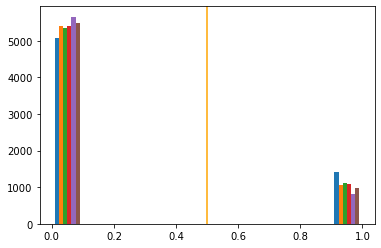

In [54]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [55]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


93.79246448424954

In [56]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [57]:
"{:0.2f}".format(pct_auc)

'96.28'

In [58]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [59]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [60]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [46]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_lstm_4,n_lstm_3,n_lstm_2,n_lstm_1,n_dense_2,n_dense_1,dropout_2,dropout_1,drop_lstm_4,drop_lstm_3,drop_lstm_2,drop_lstm_1,activation_dense,activation_conv,mean,std
5,256,256,256,128,512,512,0.2,0.3,0.02,0.10,0.02,0.02,<tensorflow.python.keras.layers.advanced_activ...,elu,0.924929,0.000526
15,128,256,128,256,384,256,0.3,0.2,0.10,0.10,0.02,0.02,<tensorflow.python.keras.layers.advanced_activ...,elu,0.924311,0.001459
6,256,128,128,256,384,256,0.2,0.3,0.02,0.10,0.10,0.02,elu,<tensorflow.python.keras.layers.advanced_activ...,0.923316,0.002471
9,256,128,128,256,256,256,0.3,0.2,0.10,0.10,0.10,0.02,elu,relu,0.922218,0.000799
1,256,256,256,128,256,512,0.3,0.2,0.02,0.02,0.10,0.02,elu,relu,0.921497,0.003644
10,256,128,128,256,256,512,0.2,0.3,0.02,0.10,0.10,0.02,<tensorflow.python.keras.layers.advanced_activ...,relu,0.920382,0.002315
17,256,128,128,256,384,384,0.2,0.3,0.02,0.02,0.02,0.02,relu,relu,0.919386,0.003320
18,256,256,128,256,384,256,0.3,0.3,0.02,0.02,0.02,0.02,<tensorflow.python.keras.layers.advanced_activ...,<tensorflow.python.keras.layers.advanced_activ...,0.919232,0.002112
2,256,256,128,256,384,512,0.3,0.2,0.10,0.10,0.02,0.02,relu,<tensorflow.python.keras.layers.advanced_activ...,0.914359,0.004164
13,256,256,128,128,384,512,0.2,0.3,0.02,0.10,0.02,0.10,relu,<tensorflow.python.keras.layers.advanced_activ...,0.897440,0.004250


## Creating best model from the best param and train it for 60 epochs

In [47]:
rscv_results.best_params_

{'n_lstm_4': 256,
 'n_lstm_3': 256,
 'n_lstm_2': 256,
 'n_lstm_1': 128,
 'n_dense_2': 512,
 'n_dense_1': 512,
 'dropout_2': 0.2,
 'dropout_1': 0.3,
 'drop_lstm_4': 0.02,
 'drop_lstm_3': 0.1,
 'drop_lstm_2': 0.02,
 'drop_lstm_1': 0.02,
 'activation_dense': <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x1b6fb510788>,
 'activation_conv': 'elu'}

In [67]:
n_lstm_4 = 256
n_lstm_3 = 256
n_lstm_2 = 256
n_lstm_1 = 128
n_dense_2 = 512
n_dense_1 = 512
dropout_2 = 0.2
dropout_1 = 0.3
drop_lstm_4 = 0.02
drop_lstm_3 = 0.1
drop_lstm_2 = 0.02
drop_lstm_1 = 0.02
activation_dense = LeakyReLU()
activation_conv = 'elu'
model = Sequential()
# LSTM layers
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                         return_sequences=True, input_shape=input_shape[1:])) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                         return_sequences=True))
model.add(LSTM(n_lstm_3, dropout=drop_lstm_3, 
                         return_sequences=True)) 
model.add(LSTM(n_lstm_4, dropout=drop_lstm_4, 
                         return_sequences=True))

# Dense layers
model.add(Flatten())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [68]:
output_dir= 'model_ouput/Final-LSTM'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [69]:
epochs = 120
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/120
228/228 [==============================] - 36s 157ms/step - loss: 1.1734 - accuracy: 0.4994 - val_loss: 0.9245 - val_accuracy: 0.6177
Epoch 2/120
228/228 [==============================] - 35s 156ms/step - loss: 0.7879 - accuracy: 0.6698 - val_loss: 0.6506 - val_accuracy: 0.7326
Epoch 3/120
228/228 [==============================] - 36s 156ms/step - loss: 0.6340 - accuracy: 0.7362 - val_loss: 0.5323 - val_accuracy: 0.7925
Epoch 4/120
228/228 [==============================] - 36s 157ms/step - loss: 0.5332 - accuracy: 0.7819 - val_loss: 0.4690 - val_accuracy: 0.8150
Epoch 5/120
228/228 [==============================] - 36s 157ms/step - loss: 0.4703 - accuracy: 0.8114 - val_loss: 0.4224 - val_accuracy: 0.8380
Epoch 6/120
228/228 [==============================] - 36s 158ms/step - loss: 0.4292 - accuracy: 0.8309 - val_loss: 0.4012 - val_accuracy: 0.8400
Epoch 7/120
228/228 [==============================] - 36s 158ms/step - loss: 0.3956 - accuracy: 0.8467 - val_loss: 0.3715 -

KeyboardInterrupt: 

In [ ]:
model.load_weights(output_dir+"/weights.100.hdf5") # 96.32

In [ ]:
y_hat = model.predict(X_valid)

In [ ]:
len(y_hat)

In [ ]:
y_hat[0]

In [ ]:
y_valid[0]

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

In [ ]:
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

In [ ]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [ ]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [ ]:
ydf.head(10)